In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

In [2]:
df = pd.read_csv('src/raw.csv')
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


(    Loan_ID Gender Married Dependents     Education Self_Employed  \
 0  LP001002   Male      No          0      Graduate            No   
 1  LP001003   Male     Yes          1      Graduate            No   
 2  LP001005   Male     Yes          0      Graduate           Yes   
 3  LP001006   Male     Yes          0  Not Graduate            No   
 4  LP001008   Male      No          0      Graduate            No   
 
    ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
 0             5849                0.0         NaN             360.0   
 1             4583             1508.0       128.0             360.0   
 2             3000                0.0        66.0             360.0   
 3             2583             2358.0       120.0             360.0   
 4             6000                0.0       141.0             360.0   
 
    Credit_History Property_Area Loan_Status  
 0             1.0         Urban           Y  
 1             1.0         Rural           N  
 2 

In [3]:
df_temp = df.copy()

In [4]:
# Drop all the missing value
df_temp = df.dropna()

#Loan_ID
# Drop the Loan ID
df_temp = df_temp.drop('Loan_ID', axis=1)

#Gender
# Drop the Gender
df_temp = df_temp.drop("Gender", axis=1)

#Married
# Converting to binary values ​​using OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform='pandas')
# encoder.fit_transform(y) is the process of learning the existing pattern in y and transforming it into an integer representation according to the index assigned to each unique value in the array y
Married_ohe = encoder.fit_transform(df_temp[['Married']]).astype(int)
# Combining df Married_ohe with df_temp and deleting the old Married column to become a new Married Column with values ​​in the form of binary values
df_temp = pd.concat([df_temp, Married_ohe], axis=1).drop(columns=['Married'])
# Married = 1; Not Married = 0
df_temp = df_temp.rename(columns={"Married_Yes": "Married"})
df_temp = df_temp.drop(columns=['Married_No'])
df_temp

#Dependents
# Change the Dependents "+" sign and data type
df_temp['Dependents'] = df_temp['Dependents'].apply(lambda x:re.sub(r'[/\+/g]', '', x)).astype(int)

#Education
# Change the data form in the Education feature to binary values
Education_ohe = encoder.fit_transform(df_temp[['Education']]).astype(int)
# Combining Education_ohe with df_temp
df_temp = pd.concat([df_temp, Education_ohe], axis=1).drop(columns=['Education'])
# Graduate = 1; Not Graduate = 0
df_temp = df_temp.rename(columns={"Education_Graduate": "Education"})
df_temp = df_temp.drop(columns=["Education_Not Graduate"])

#Self_Employed
# Change the data form in the Self_Employed feature to binary values
Self_Employed_ohe = encoder.fit_transform(df_temp[['Self_Employed']]).astype(int)
# Combining Educatio_ohe with df_temp
df_temp = pd.concat([df_temp, Self_Employed_ohe], axis=1).drop(columns=['Self_Employed'])
# Self_Employed_Yes = 1; Self_Employed_No = 0
df_temp = df_temp.rename(columns={"Self_Employed_Yes": "Self_Employed"})
df_temp = df_temp.drop(columns=['Self_Employed_No'])

#Income
# Combine the Applicant and Coapplicant Income
df_temp['Income'] = (df_temp['ApplicantIncome'] + df_temp['CoapplicantIncome']).astype(int)
df_temp = df_temp.drop('ApplicantIncome', axis = 1)
df_temp = df_temp.drop('CoapplicantIncome', axis = 1)
df_temp.head()

# Manipulate LoanAmount (add thousands)
df_temp["LoanAmount"] = (df_temp["LoanAmount"].mul(1000)).astype(int)
df_temp = df_temp.drop(df_temp[df_temp["LoanAmount"] > 350000].index)
df_temp = df_temp.drop(df_temp[df_temp["Income"] > 20000].index)

#Loan_Amount_Term
df_temp['Loan_Amount_Term'] = df_temp['Loan_Amount_Term'].astype(int)

#Credit_History
df_temp['Credit_History'] = df_temp['Credit_History'].astype(int)

#Property_Area
Property_Area_ohe = encoder.fit_transform(df_temp[['Property_Area']]).astype(int)
# Menggabungkan Property_Area_ohe menjadi satu
df_temp = pd.concat([df_temp, Property_Area_ohe], axis=1).drop(columns=['Property_Area'])

#Loan_Status
# Changed Loan_Status to OneHotEncoder
Loan_Status_ohe = encoder.fit_transform(df_temp[['Loan_Status']]).astype(int)
# Combine Loan_Status_ohe with df_temp
df_temp = pd.concat([df_temp, Loan_Status_ohe], axis=1).drop(columns=['Loan_Status'])
# Loan Status Yes = 1; Loan Status No = 0
df_temp = df_temp.rename(columns={"Loan_Status_Y": "Loan_Status"})
df_temp = df_temp.drop(columns=['Loan_Status_N'])
# Loan_Status condition after OneHotEncoding
df_temp.head()

,Dependents,LoanAmount,Loan_Amount_Term,Credit_History,Married,Education,Self_Employed,Income,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
1,1,128000,360,1,1,1,0,6091,1,0,0,0
2,0,66000,360,1,1,1,1,3000,0,0,1,1
3,0,120000,360,1,1,0,0,4941,0,0,1,1
4,0,141000,360,1,0,1,0,6000,0,0,1,1
5,2,267000,360,1,1,1,1,9613,0,0,1,1


In [29]:
df_temp.loc[399]

Dependents                      0
LoanAmount                 103000
Loan_Amount_Term              360
Credit_History                  0
Married                         0
Education                       1
Self_Employed                   0
Income                       3300
Property_Area_Rural             0
Property_Area_Semiurban         1
Property_Area_Urban             0
Loan_Status                     0
Name: 399, dtype: int32

In [5]:
# To get to know the unique value in every features
for col in df_temp.select_dtypes(include=['object', 'bool', 'float64', 'int64', 'int32']).columns:
    print(col)
    print(df_temp[col].unique())
    print()

Dependents
[1 0 2 3]

LoanAmount
[128000  66000 120000 141000 267000  95000 158000 168000  70000 200000
 114000  17000 125000  76000 133000 104000 315000 116000 191000 122000
 110000  35000  74000 106000 320000 144000 184000  80000  47000 134000
  44000 100000 112000 286000  97000  96000 135000 180000  99000 165000
 258000 126000 312000 136000 172000  81000 187000 113000 176000 111000
 167000  50000 210000 175000 131000 188000  25000 137000 115000 151000
 225000 216000  94000 185000 154000 259000 194000 160000 102000 290000
  84000  88000 242000 129000  30000 118000 152000 244000 255000  98000
 275000 121000  75000  63000  87000 101000  73000 108000  48000 164000
 170000  83000  90000 166000 124000  55000  59000 127000 214000 240000
 130000  60000 280000 140000 155000 123000 201000 138000 279000 192000
 304000 150000 207000  78000  54000  89000 139000  93000 132000  56000
 300000  67000 117000  71000 173000  46000 228000 308000 105000 236000
 296000 156000 109000 103000  45000  65000  

In [6]:
X = df_temp.drop(columns="Loan_Status", axis=1)
y = df_temp["Loan_Status"]

In [7]:
# Seperate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape

((368, 11), (92, 11))

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# First of all we create function to evaluate our models

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_preds labels on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    # metric_dict = {"accuracy": round(accuracy, 2),
    #                 "precision": round(precision, 2),
    #                 "recall": round(recall, 2),
    #                 "f1": round(f1, 2)}

    return accuracy, precision, recall, f1

In [9]:
models = {
    "LinearSVC" : LinearSVC(),
    "RandomForest Classification": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=False)
}
model_list = []
f1_list = []

np.random.seed(42)

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate train and test dataset
    model_train_accuracy, model_train_precision, model_train_recall, model_train_f1 = evaluate_preds(y_train, y_train_pred)
    model_test_accuracy, model_test_precision, model_test_recall, model_test_f1 = evaluate_preds(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print("Model Performance for Training set")
    print("- Accuracy :{:.4f}".format(model_train_accuracy))
    print("- Precision :{:.4f}".format(model_train_precision))
    print("- Recall :{:.4f}".format(model_train_recall))
    print("- F1 Score :{:.4f}".format(model_train_f1))
    
    print("------------------------------------------")

    print("Model Performance for Test set")
    print("- Accuracy :{:.4f}".format(model_test_accuracy))
    print("- Precision :{:.4f}".format(model_test_precision))
    print("- Recall :{:.4f}".format(model_test_recall))
    print("- F1 Score :{:.4f}".format(model_test_f1))
    f1_list.append(model_test_f1)

    print('='*35)
    print('\n')


LinearSVC
Model Performance for Training set
- Accuracy :0.6984
- Precision :0.6967
- Recall :1.0000
- F1 Score :0.8213
------------------------------------------
Model Performance for Test set
- Accuracy :0.7283
- Precision :0.7283
- Recall :1.0000
- F1 Score :0.8428




d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomForest Classification
Model Performance for Training set
- Accuracy :1.0000
- Precision :1.0000
- Recall :1.0000
- F1 Score :1.0000
------------------------------------------
Model Performance for Test set
- Accuracy :0.8261
- Precision :0.8400
- Recall :0.9403
- F1 Score :0.8873


KNeighborsClassifier
Model Performance for Training set
- Accuracy :0.7065
- Precision :0.7319
- Recall :0.9098
- F1 Score :0.8112
------------------------------------------
Model Performance for Test set
- Accuracy :0.6630
- Precision :0.7250
- Recall :0.8657
- F1 Score :0.7891




d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
Model Performance for Training set
- Accuracy :0.8071
- Precision :0.7968
- Recall :0.9686
- F1 Score :0.8743
------------------------------------------
Model Performance for Test set
- Accuracy :0.8370
- Precision :0.8333
- Recall :0.9701
- F1 Score :0.8966


DecisionTreeClassifier
Model Performance for Training set
- Accuracy :1.0000
- Precision :1.0000
- Recall :1.0000
- F1 Score :1.0000
------------------------------------------
Model Performance for Test set
- Accuracy :0.6848
- Precision :0.8065
- Recall :0.7463
- F1 Score :0.7752


XGBClassifier
Model Performance for Training set
- Accuracy :1.0000
- Precision :1.0000
- Recall :1.0000
- F1 Score :1.0000
------------------------------------------
Model Performance for Test set
- Accuracy :0.7609
- Precision :0.8169
- Recall :0.8657
- F1 Score :0.8406


CatBoostClassifier
Model Performance for Training set
- Accuracy :0.9130
- Precision :0.8912
- Recall :0.9961
- F1 Score :0.9407
--------------------------------

In [10]:
pd.DataFrame(list(zip(model_list, f1_list)), columns=['Model Name', 'F1 Score']).sort_values(by=["F1 Score"], ascending=False)

,Model Name,F1 Score
3,LogisticRegression,0.896552
6,CatBoostClassifier,0.888889
1,RandomForest Classification,0.887324
0,LinearSVC,0.842767
5,XGBClassifier,0.840580
2,KNeighborsClassifier,0.789116
4,DecisionTreeClassifier,0.775194


# LogisticRegression

In [11]:
clf_LR = LogisticRegression(fit_intercept=True)
clf_LR = clf_LR.fit(X_train, y_train)
y_pred = clf_LR.predict(X_test)
baseline_LR = evaluate_preds(y_test, y_pred)
score = f1_score(y_test, y_pred)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 89.66


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
pred_df = pd.DataFrame({'Actual Value':y_test, 'Predicted Value': y_pred, 'Difference': y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
163,1,1,0
41,1,1,0
261,1,1,0
586,1,1,0
205,1,1,0
...,...,...,...
399,0,0,0
60,1,1,0
137,1,1,0
554,0,0,0


# Improved Logistic Regression

In [13]:
import pandas as pd
def compare(baseline_metrics, rs_metrics, gs_metrics, title):
    compare_metrics = pd.DataFrame({
        "baseline": baseline_metrics,
        "random search": rs_metrics,
        "grid search": gs_metrics
    })
    ax = compare_metrics.plot.bar(figsize=(10,8))
    ax.set_title(title)
    return ax

In [14]:
clf_LR.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [15]:
grid_LR = {
    "C": [1.0, 1.5, 2.0],
    "max_iter": [1, 5, 10, 100, 1000],
    "n_jobs":[None]
}

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Setup RandomizedSearchCV to search the best parameters
rs_clf_LR = RandomizedSearchCV(estimator=clf_LR,
                                param_distributions=grid_LR,
                                n_iter=80, # Number of models to try
                                cv=5,
                                verbose=2)

rs_clf_LR.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .....................C=1.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=5, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 15 is smaller than n_iter=80. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

[CV] END .....................C=1.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=100, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ...................C=1.0, max_iter=100, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.2s
[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.1s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=1.5, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END ...................

d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ....................C=1.5, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.5, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.5, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.5, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.5, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.5, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.5, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.5, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.5, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.5, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.5, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.5, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=1, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END .....................C=2.0, max_iter=5, n_jobs=None; total time=   0.0s
[CV] END ...................

d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ...................C=2.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
rs_clf_LR.best_params_

{'n_jobs': None, 'max_iter': 1000, 'C': 1.0}

In [18]:
# Evaluating the model
# Make predictions with the best hyperparameters
rs_y_preds_LR = rs_clf_LR.predict(X_test)

# Evaluate the predictions
rs_metrics_LR = evaluate_preds(y_test, rs_y_preds_LR)

In [19]:
grid_LR_2 = {
    "C": [1.0, 2.0, 3.0],
    "max_iter": [10, 50, 100, 200, 1000, 1200],
    "n_jobs":[None]
}

In [20]:
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Setup GridSearchCV
gs_clf_LR = GridSearchCV(estimator=clf_LR,
                            param_grid=grid_LR_2,
                            cv=5,
                            verbose=2)

# Fit the GridSearchCV version of clf
gs_clf_LR.fit(X_train, y_train);

d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=1.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=100,

d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ...................C=1.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=1.0, max_iter=200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.1s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.0, max_iter=1000, n_jobs=None; total time=   0.1s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.0, max_iter=1200, n_jobs=None; total time=   0.1s
[CV] END ..................C=1.0, max_iter=1200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=1.0, max_iter=1200, n_jobs=None; total time=   0.0s
[CV] END ..................C=1.0, max_iter=1200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=1.0, max_iter=1200, n_jobs=None; total time=   0.3s
[CV] END ....................C=2.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=2.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................

d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ...................C=2.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=2.0, max_iter=200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=2.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=2.0, max_iter=1200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=2.0, max_iter=1200, n_jobs=None; total time=   0.1s
[CV] END ..................C=2.0, max_iter=1200, n_jobs=None; total time=   0.1s
[CV] END ..................C=2.0, max_iter=1200, n_jobs=None; total time=   0.1s
[CV] END ..................C=2.0, max_iter=1200, n_jobs=None; total time=   0.1s
[CV] END ....................C=3.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=10, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=50, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ....................C=3.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ....................C=3.0, max_iter=50, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=100, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ...................C=3.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ...................C=3.0, max_iter=200, n_jobs=None; total time=   0.0s
[CV] END ..................C=3.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=3.0, max_iter=1000, n_jobs=None; total time=   0.1s
[CV] END ..................C=3.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=3.0, max_iter=1000, n_jobs=None; total time=   0.0s
[CV] END ..................C=3.0, max_iter=1000, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV] END ..................C=3.0, max_iter=1200, n_jobs=None; total time=   0.1s
[CV] END ..................C=3.0, max_iter=1200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=3.0, max_iter=1200, n_jobs=None; total time=   0.0s
[CV] END ..................C=3.0, max_iter=1200, n_jobs=None; total time=   0.0s
[CV] END ..................C=3.0, max_iter=1200, n_jobs=None; total time=   0.0s


d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Implemented_AI\Fraud_Detection\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [21]:
gs_clf_LR.best_params_

{'C': 1.0, 'max_iter': 200, 'n_jobs': None}

In [22]:
# Evaluating the model
# Make predictions with the best hyperparameters
gs_y_preds_LR = gs_clf_LR.predict(X_test)

# Evaluate the predictions
gs_metrics_LR = evaluate_preds(y_test, gs_y_preds_LR)

<Axes: title={'center': 'Comparison of Logistic Regression Classifier'}>

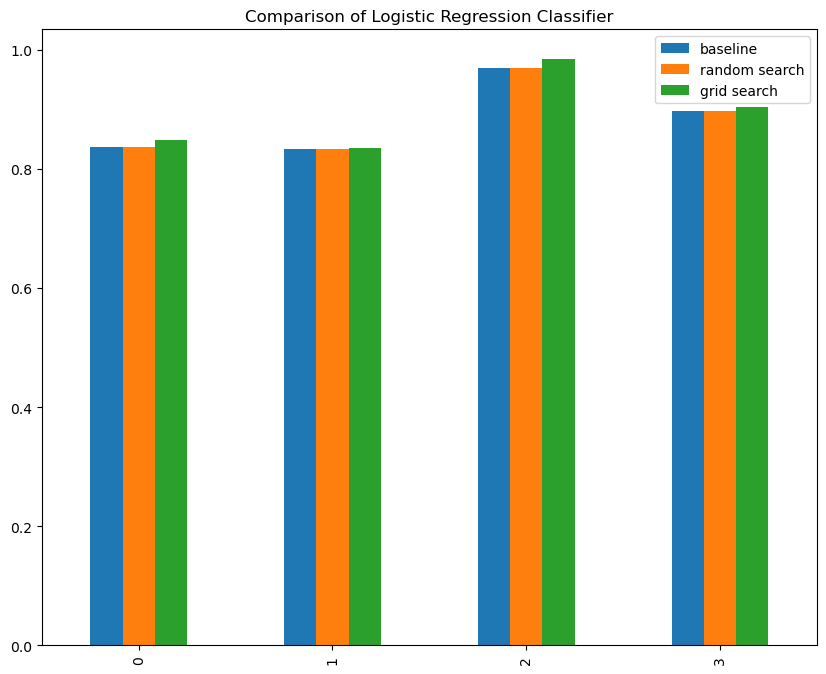

In [23]:
compare(baseline_LR, rs_metrics_LR, gs_metrics_LR, title="Comparison of Logistic Regression Classifier")

In [24]:
# Save the model into pickle file
import pickle
pickle.dump(gs_clf_LR, open("model.pkl", "wb"))